# 03.4 Ejercicio de Clustering con fichero de semillas

El objetivo del cuaderno es hacer una agrupación del archivo de semillas según sus características y ver que tal separa en sus diferentes etiquetas

Para calcular la tasa de aciertos visualmente asignaremos los cluster generados a las etiquetas reales. En la rutina de recuento se utiliza la variable __equivalencia__ para indicar dicha correspondencia.

In [1]:
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd
import numpy as np
from skimage import io
from IPython import display

Se va a utilizar __K-means__ y varios __métodos jerárquicos__ para agrupar 210 instancias de __semillas de trigo__. El conjunto de datos esta en el archivo seeds.csv que puedes descargar de Moodle. Se muestrearon aleatoriamente 70 semillas de tres variedades de trigo; kama, rosa y canadiense (listados como 1, 2 y 3 en la columna species class).

De las 210 observaciones se midieron, utilizando tecnicas precisas, los siguientes atributos: __"área, perímetro, compactividad, longitud, anchura, coeficiente de asimetría, longitud del canal"__.

## Carga del archivo en un dataframe

In [2]:
df = pd.read_csv('data/seeds.csv')
df.head()

,area,perimeter,compactness,length,width,asymmetry,groove_length,species_class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


### Se estandariza el conjunto de datos

Con eso se evita que la diferencias de magnitud entre cada característica afecte al clustering

In [3]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
df[["area","perimeter","compactness","length","width","asymmetry","groove_length"]] = sc.fit_transform(df[["area",
    "perimeter","compactness","length","width","asymmetry","groove_length"]])
df.head()

,area,perimeter,compactness,length,width,asymmetry,groove_length,species_class
0,0.142098,0.215462,0.000061,0.304218,0.141702,-0.986152,-0.383577,1
1,0.011188,0.008224,0.428515,-0.168625,0.197432,-1.788166,-0.922013,1
2,-0.192067,-0.360201,1.442383,-0.763637,0.208048,-0.667479,-1.189192,1
3,-0.347091,-0.475333,1.039381,-0.688978,0.319508,-0.960818,-1.229983,1
4,0.445257,0.330595,1.374509,0.066666,0.805159,-1.563495,-0.475356,1


### Construcción de la matriz X de características + la matriz y de etiquetas

- Las características están en las 7 primeras columnas __¿duda preguntar si es hasta la 6 o hasta la 7 en el X?__
- Las etiquetas en la columna 8 (species_class)

In [4]:
X = df.values[:,0:7]
y_ini = df.values[:,7]

In [5]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y=le.fit_transform(y_ini)

### Visualización gráfica de los datos

Se presenta en un gráfico bidimensional dos de las características (área y perímetro) y la etiqueta que identifica cada clase en y se representa con una viñeta distinta al dibujar el punto.

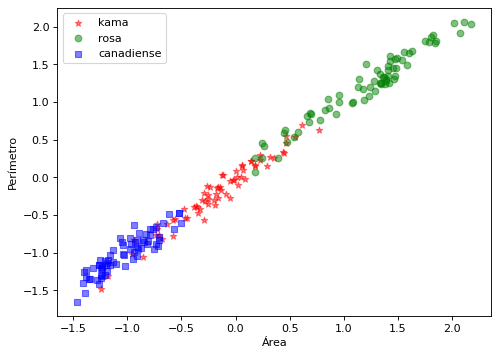

In [6]:
import matplotlib.pyplot as plt
clases = ['kama','rosa','canadiense']
marcas = ['*', 'o', 's']
color = ['red', 'green', 'blue']
plt.figure(figsize=(7, 5), dpi=80)
for i in range(len(clases)):
    plt.scatter(X[y==i,0], X[y==i,1], c=color[i], alpha=0.5, marker=marcas[i], label=clases[i])
plt.xlabel("Área")
plt.ylabel("Perímetro")
plt.legend(loc='upper left')
plt.show()

Se llevará a cabo una agrupación de 3 grupos (__n_cluster__), se ejecuta el algoritmo 10 veces (__n_init__) independientemente con diferentes centroides aleatorios para elegir el modelo final que tiene el SSE más bajo. Se elege una tolerancia (__tol__) de 0.0001 ($10^{-4}$) para controlar la convergencia de los mínimos cuadrados.

Un problema con k-means es que uno o más grupos pueden estar vacíos. Sin embargo, en la implementación actual de kmeans en scikit-learn, si un grupo está vacío, el algoritmo buscará la muestra más alejada del centroide del grupo vacío. Luego reasignará el centroide para que sea el punto más alejado.

In [7]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=1)
y_km = km.fit_predict(X)
np.unique(y_km)

array([0, 1, 2])

__Mostrar las coordenadas de los centroides usando un DataFrame__

In [8]:
df1=pd.DataFrame(columns=df.columns[0:7],index = np.arange(3),data = km.cluster_centers_)
df1

,area,perimeter,compactness,length,width,asymmetry,groove_length
0,-0.141119,-0.170043,0.449606,-0.257814,0.001647,-0.661919,-0.585893
1,-1.030253,-1.006649,-0.964905,-0.897685,-1.085583,0.694804,-0.624809
2,1.256682,1.261966,0.560464,1.237883,1.164852,-0.045219,1.292308


La visualización del ajuste realizado es el siguiente:

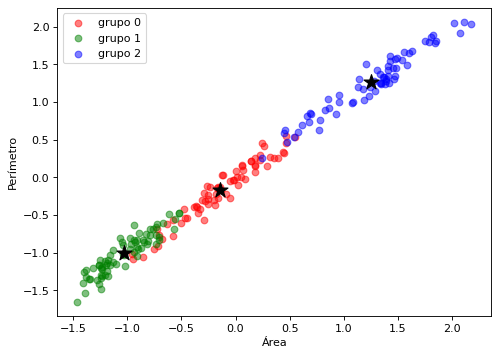

In [9]:
import matplotlib.pyplot as plt
clases = ['grupo 0','grupo 1','grupo 2']
color = ['red', 'green', 'blue']
plt.figure(figsize=(7, 5), dpi=80)
for i in range(len(clases)):
    plt.scatter(X[y_km==i,0], X[y_km==i,1], c=color[i], alpha=0.5, marker='o', label=clases[i])
x1=df1.values[:,0]
y1=df1.values[:,1]
plt.scatter(x1, y1, marker="*", s=200, c='k')
plt.xlabel("Área")
plt.ylabel("Perímetro")
plt.legend(loc='upper left')
plt.show()

### Se evalúa la calidad del método

Calcular los índices __R__ , __ARI__ , __VI__ y __AVI__ comparando contra las etiquetas reales de 'species_class' .

In [10]:
from sklearn.metrics.cluster import rand_score
from sklearn.metrics.cluster import adjusted_rand_score
print("KMeans  R=%.3f ARI=%.3f" %(rand_score(labels_true=y, labels_pred=y_km), adjusted_rand_score(labels_true=y, labels_pred=y_km)))

KMeans  R=0.900 ARI=0.773


In [11]:
run 03.0ClusteringUtilidades.ipynb #Si la ejecución de esta celda da error, revisar el nombre del cuaderno

load done!


In [12]:
print("KMeans  VI=%.3f AVI=%.3f  NVI=%.3f" %(variationInformation(y, y_km), adjustedVariationInformation(y, y_km), 
                                             normalizedVariationInformation(y, y_km)))

KMeans  VI=0.598 AVI=0.112  NVI=0.272


## Nuevo proceso con Cluster jerárquico

Se resuelve un cluster aglomerativo con __scikit-learn__ que es __AgglomerativeClustering__:

In [13]:
from sklearn.cluster import AgglomerativeClustering
ac = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete')
y_ag = ac.fit_predict(X)
etiquetas=np.unique(y_ag) 
etiquetas

array([0, 1, 2], dtype=int64)

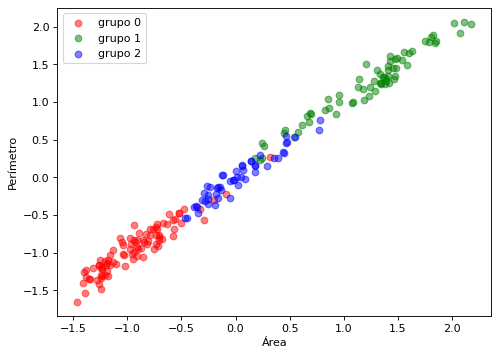

In [14]:
import matplotlib.pyplot as plt
names = ['grupo 0', 'grupo 1', 'grupo 2']
color = ['red', 'green', 'blue']
plt.figure(figsize=(7, 5), dpi=80)
for i in range(len(names)):
    cl = i
    plt.scatter(X[y_ag==cl,0], X[y_ag==cl,1], c=color[i], alpha=0.5, marker='o', label=names[i])
plt.xlabel("Área")
plt.ylabel("Perímetro")
plt.legend(loc='upper left')
plt.show()

### Se evalúa la calidad del método

Calcular los índices __R__ , __ARI__ , __VI__ y __AVI__ comparando contra las etiquetas reales de 'species_class' .

In [15]:
run 03.0ClusteringUtilidades.ipynb #Si la ejecución de esta celda da error, revisar el nombre del cuaderno

load done!


In [17]:
from sklearn.metrics.cluster import rand_score
from sklearn.metrics.cluster import adjusted_rand_score
print("AgglomerativeClustering R=%.3f ARI=%.3f" %(rand_score(labels_true=y, labels_pred=y_ag), adjusted_rand_score(labels_true=y, labels_pred=y_ag)))

AgglomerativeClustering R=0.859 ARI=0.686


In [18]:
print("AgglomerativeClustering VI=%.3f AVI=%.3f  NVI=%.3f" %(variationInformation(y, y_ag), adjustedVariationInformation(y, y_ag), 
                                             normalizedVariationInformation(y, y_ag)))

AgglomerativeClustering VI=0.650 AVI=0.121  NVI=0.299


__¿Qué clustering ha resultado más optimo?__

Para los valores del ídice de Rand, cuanto más cercanos a __1__ son, mejor ha  sido la agrupación. El clustering más óptimo se ha obtenido por KMeans ya que __R=0.900__, más alto que el __R=0.859__ del Clustering Jeráquíco. En el caso del índice VI, cuanto más cercanos a __0__ son los valores, mejor ha sido la agrupación. El Clustering realizado por KMeans tiene un valor más bajo de __VI__ (__VI=0.598__) que el obtenido por Clustering Jerárquíco (__VI=0.650__), todo esto indicando que el método KMeans ha sido más óptimo para agrupar.

## Estudio del número de grupos óptimos (gráfico del codo y bic)

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


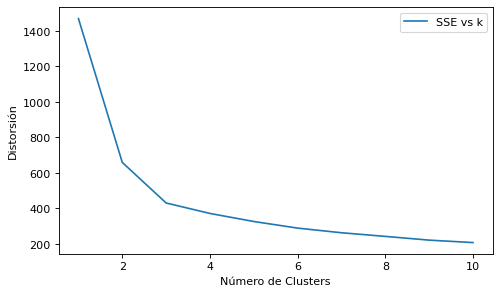

In [19]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, init='k-means++', max_iter=300, tol=1e-04, random_state=1)
    km.fit(X)
    distortions.append(km.inertia_)
plt.figure(figsize=(7, 4), dpi=80)
plt.plot(range(1,11), distortions, label="SSE vs k")
plt.xlabel("Número de Clusters")
plt.ylabel("Distorsión")
plt.legend(loc='upper right')
plt.show()

Según el gráfico del codo, el número de grupos óptimos sería de __2__ ó __3__ clusters.

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


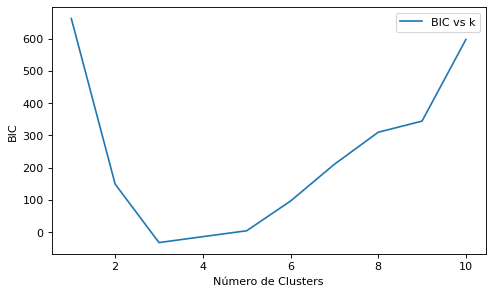

In [62]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
bic = []
for i in range(1, 11):
    gmm = GaussianMixture(n_components=i, init_params='kmeans')
    gmm.fit(X)
    bic.append(gmm.bic(X))

plt.figure(figsize=(7, 4), dpi=80)
plt.plot(range(1,11), bic, label="BIC vs k")
plt.xlabel("Número de Clusters")
plt.ylabel("BIC")
plt.legend(loc='upper right')
plt.show()    

Se debe elegir el número de clusters que minimiza el BIC. Según el gráfico obtenido, el número de grupos óptimos es el de __3 clusters__.